In [1]:
from pathlib import Path
import numpy as np
from scipy import interpolate as intp
import matplotlib.pyplot as plt
import tfs
import json
import toolkit.create_error_table as cet

from cpymad.madx import Madx

import logging
import pandas as pd
import os
import sys
from optics_functions.coupling import coupling_via_cmatrix, closest_tune_approach,coupling_via_rdts
from optics_functions.utils import split_complex_columns
from optics_functions.rdt import calculate_rdts, generator, jklm2str
from optics_functions.utils import prepare_twiss_dataframe, split_complex_columns

%matplotlib notebook

In [2]:
# Define the beam and run the twiss

from cpymad.madx import Madx # LC = linear combination
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl


madx = Madx(stdout=False)

madx.option(echo=True)

madx.call(file='Z_sequence.seq')
madx.command.beam(sequence='FCCEE_P_RING', particle = 'ELECTRON', energy=45.6)
madx.call(file='install_orbit_correctors.madx')
madx.input('USE, SEQUENCE = FCCEE_P_RING;')

madx.input('''

SELECT,FLAG=TWISS,CLEAR=TRUE;
Select, flag=twiss, column=name,keyword,s,k1l,k2l,k1sl,l,betx,bety,alfx,alfy,dx,dpx,dy,dpy,r11,r12,r21,r22,x,y,px,py;
TWISS, FILE = "twiss_without_bety_errors.tfs"; 


''')



twiss1=tfs.read('twiss_without_bety_errors.tfs')

# twiss1 = madx.twiss(sequence = 'FCCEE_P_RING')

In [3]:
# Generate response matrix by tuning the quadrupoles in the matching section and final-focus section

# # 1- Selecting the 10 first and 10 last quadrupoles
N = ['QB6.1','QB5.1','QB4.1','QB3.1','QB2.1','QB1.1','QC2L2.1','QC2L1.1','QC1L3.1','QC1L2.1','QC1L1.2','QC1L1.3','QC1R2.2','QC1R3.2','QC2R1.2','QC2R2.2','QA1.2','QA2.2','QA3.2','QA4.2','QA5.2','QA6.2']

K = [] # in this vector are going to be stored all the quadrupoles strength by order growing s
for i in range(len(N)):
#     index = twiss1.index[np.where(twiss1['NAME'] == N[i])[0][0]] #finding the index of the first desired magnet in the twiss table
    k1= twiss1.K1L[np.where(twiss1['NAME'] == N[i])[0][0]]/twiss1.L[np.where(twiss1['NAME'] == N[i])[0][0]]
    K.append(k1)

dk = 10**-6 

dbetxw = np.zeros(len(N))
dbetyw = np.zeros(len(N))
dwx = np.zeros(len(N))
dwy = np.zeros(len(N))
dQx = np.zeros(len(N))
dQy = np.zeros(len(N))

betx_0 = twiss1.BETX[np.where(twiss1['NAME'] == 'IP.2')[0][0]]
bety_0 = twiss1.BETY[np.where(twiss1['NAME'] == 'IP.2')[0][0]]
alfx_0 = twiss1.ALFX[np.where(twiss1['NAME'] == 'IP.2')[0][0]]
alfy_0 = twiss1.ALFY[np.where(twiss1['NAME'] == 'IP.2')[0][0]]
Qx_0 = twiss1.headers['Q1']
Qy_0 = twiss1.headers['Q2']


betxw_0 = betx_0/(1+alfx_0**2)
betyw_0 = bety_0/(1+alfy_0**2)

dwx_0 = -betx_0*alfx_0/(1 + alfx_0**2)
dwy_0 = -bety_0*alfy_0/(1 + alfy_0**2)


for i in range(len(N)):
    madx.input(N[i] + ', K1 = ' + str(K[i]*(1+dk)) + ';')
    madx.input('''
    TWISS, FILE = "twiss_with_modified_strenghts_bety.tfs"; 
    ''')
    twiss=tfs.read('twiss_with_modified_strenghts_bety.tfs')
    
    bx = twiss.BETX[np.where(twiss['NAME'] == 'IP.2')[0][0]]
    by = twiss.BETY[np.where(twiss['NAME'] == 'IP.2')[0][0]]
    ax = twiss.ALFX[np.where(twiss['NAME'] == 'IP.2')[0][0]]
    ay = twiss.ALFY[np.where(twiss['NAME'] == 'IP.2')[0][0]]

    dbetxw[i] = (bx/(1+ax**2)/betxw_0-1)/dk
    dbetyw[i] = (by/(1+ay**2)/betyw_0-1)/dk
    dwx[i] = (-ax*bx/(1 + ax**2) - dwx_0)/dk
    dwy[i] = (-ay*by/(1 + ay**2) - dwy_0)/dk
    dQx[i] = (twiss.headers['Q1']-Qx_0)/dk
    dQy[i] = (twiss.headers['Q2']-Qy_0)/dk

    madx.input(N[i] + ', K1 = ' + str(K[i]) + ';')


In [4]:
# Construct pseudo inverse from the response matrix


Rmatrix = [dbetxw,dbetyw,dwx,dwy,dQx,dQy]

U, S, V = np.linalg.svd(Rmatrix, full_matrices = False)

S_inv = []
epsilon=0.001
for i in range(np.size(S)):
    if S[i] <= epsilon*max(S):
        S_inv.append(0)
    else:
        S_inv.append(1/S[i])
        
RM_inv = np.matmul(np.matmul(V.transpose(), np.diag(S_inv)), U.transpose())

By_knob = np.linspace(-0.3,0.3,10)


dbetxw_real = np.zeros(len(By_knob))
dbetyw_real = np.zeros(len(By_knob))
dwx_real = np.zeros(len(By_knob))
dwy_real = np.zeros(len(By_knob))
dQx_real = np.zeros(len(By_knob))
dQy_real = np.zeros(len(By_knob))

In [5]:
# Apply the correct setting of the quadrupoles with the help of pseudo inverse matrix and target matrix



for i in range(len(By_knob)):

    target = np.asarray([0,By_knob[i],0,0,0,0])
    dK = np.matmul(RM_inv,target)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]*(1+dK[j])) + ';')
#     twiss = madx.twiss(sequence = 'FCCEE_P_RING')
    madx.twiss(sequence='FCCEE_P_RING',file="twiss_with_new_modified_strenghts_bety.tfs")
#     madx.input('''
#     TWISS, FILE = "twiss_with_new_modified_strenghts.tfs"; 
#     ''')
    twiss_=tfs.read('twiss_with_new_modified_strenghts_bety.tfs')
        
    bx = twiss_.BETX[np.where(twiss_['NAME'] == 'IP.2')[0][0]]
    by = twiss_.BETY[np.where(twiss_['NAME'] == 'IP.2')[0][0]]
    ax = twiss_.ALFX[np.where(twiss_['NAME'] == 'IP.2')[0][0]]
    ay = twiss_.ALFY[np.where(twiss_['NAME'] == 'IP.2')[0][0]]

    dbetxw_real[i] = (bx/(1+ax**2)/betxw_0-1)
    dbetyw_real[i] = (by/(1+ay**2)/betyw_0-1)
    dwx_real[i] = (-ax*bx/(1 + ax**2) - dwx_0)
    dwy_real[i] = (-ay*by/(1 + ay**2) - dwy_0)
    dQx_real[i] = (twiss_.headers['Q1']-Qx_0)
    dQy_real[i] = (twiss_.headers['Q2']-Qy_0)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]) + ';')

In [6]:
# Include errors in the lattice with the help of error creation routine written in python (only arc quadrupoles are misaligned)

madx.input('''
SELECT, FLAG=error, CLEAR=True;
READMYTABLE, file='lra_errors.tfs', table=err_tab;
SETERR, TABLE=err_tab;

SELECT,FLAG=TWISS,CLEAR=TRUE;
Select, flag=twiss, column=name,keyword,s,k1l,k2l,k1sl,l,betx,bety,alfx,alfy,dx,dpx,dy,dpy,r11,r12,r21,r22,x,y,px,py;
TWISS, FILE = "twiss_with_bety_errors.tfs"; 

''')
dbetxw_error = np.zeros(len(By_knob))
dbetyw_error = np.zeros(len(By_knob))
dwx_error = np.zeros(len(By_knob))
dwy_error = np.zeros(len(By_knob))
dQx_error = np.zeros(len(By_knob))
dQy_error = np.zeros(len(By_knob))

In [7]:
# Apply the correct setting of the quadrupoles with the help of pseudo inverse matrix and target matrix (in this case, the lattice has errors)


for i in range(len(By_knob)):

    target = np.asarray([0,By_knob[i],0,0,0,0])
    dK = np.matmul(RM_inv,target)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]*(1+dK[j])) + ';')
#     twiss = madx.twiss(sequence = 'FCCEE_P_RING')
    madx.twiss(sequence='FCCEE_P_RING',file="twiss_with_errors_modified_strenghts_bety.tfs")
#     madx.input('''
#     TWISS, FILE = "twiss_with_new_modified_strenghts.tfs"; 
#     ''')
    twiss_error=tfs.read('twiss_with_errors_modified_strenghts_bety.tfs')
        
    bx = twiss_error.BETX[np.where(twiss_error['NAME'] == 'IP.2')[0][0]]
    by = twiss_error.BETY[np.where(twiss_error['NAME'] == 'IP.2')[0][0]]
    ax = twiss_error.ALFX[np.where(twiss_error['NAME'] == 'IP.2')[0][0]]
    ay = twiss_error.ALFY[np.where(twiss_error['NAME'] == 'IP.2')[0][0]]

    dbetxw_error[i] = (bx/(1+ax**2)/betxw_0-1)
    dbetyw_error[i] = (by/(1+ay**2)/betyw_0-1)
    dwx_error[i] = (-ax*bx/(1 + ax**2) - dwx_0)
    dwy_error[i] = (-ay*by/(1 + ay**2) - dwy_0)
    dQx_error[i] = (twiss_error.headers['Q1']-Qx_0)
    dQy_error[i] = (twiss_error.headers['Q2']-Qy_0)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]) + ';')

In [8]:
# perform orbit correction by installing orbit correctors upstream of the matching section with the help of madx

madx.input('''
SELECT, FLAG=error, CLEAR=True;
READMYTABLE, file='lra_errors.tfs', table=err_tab;
SETERR, TABLE=err_tab;

SELECT,FLAG=TWISS,CLEAR=TRUE;
Select, flag=twiss, column=name,keyword,s,k1l,k2l,k1sl,l,betx,bety,alfx,alfy,dx,dpx,dy,dpy,r11,r12,r21,r22,x,y,px,py;
TWISS, FILE = "twiss_with_bety_errors.tfs"; 

!for orbit corrector of length=0.0m
!hv_ql21_h          =   -7.631865913e-05 ;
!hv_ql31_h          =    9.921872883e-05 ;
!hv_ql41_h          =     1.83150486e-05 ;
!hv_ql41_r_h        =   -2.300758021e-05 ;

!hv_ql21_v          =   -1.625424562e-07 ;
!hv_ql31_v          =    3.116287878e-07 ;
!hv_ql41_v          =   -6.713234505e-06 ;
!hv_ql41_r_v        =   -5.169513424e-06 ;

!for orbit corrector of length=0.2m
hv_ql21_h          =   -4.842056509e-05 ;
hv_ql31_h          =    3.383221642e-05 ;
hv_ql41_h          =     2.73720883e-05 ;
hv_ql41_r_h        =   -1.292050984e-05 ;

hv_ql21_v          =    3.623941431e-07 ;
hv_ql31_v          =   -2.304562464e-07 ;
hv_ql41_v          =   -6.358167887e-06 ;
hv_ql41_r_v        =   -5.139562632e-06 ;


!for orbit corrector of length=0.1m


!hv_ql21_h          =   -4.898499514e-05 ;
!hv_ql31_h          =    3.586574859e-05 ;
!hv_ql41_h          =    1.519094894e-05 ;
!hv_ql41_r_h        =   -1.902920229e-06 ;

!hv_ql21_v          =    1.076184722e-06 ;
!hv_ql31_v          =   -1.426174666e-06 ;
!hv_ql41_v          =   -7.787726529e-07 ;
!hv_ql41_r_v        =   -9.705538213e-06 ;

!for orbit corrector of length=0.3m
!hv_ql21_h          =      -2.047499e-05 ;
!hv_ql31_h          =   -3.139695802e-05 ;
!hv_ql41_h          =    3.286599558e-05 ;
!hv_ql41_r_h        =    3.256305131e-07 ;

!hv_ql21_v          =    1.353221785e-07 ;
!hv_ql31_v          =    8.600304829e-08 ;
!hv_ql41_v          =    -7.24509948e-06 ;
!hv_ql41_r_v        =    -4.49517175e-06 ;

SELECT,FLAG=TWISS,CLEAR=TRUE;
Select, flag=twiss, column=name,keyword,s,k1l,k2l,k1sl,l,betx,bety,alfx,alfy,dx,dpx,dy,dpy,r11,r12,r21,r22,x,y,px,py;
TWISS, FILE = "twiss_with_bety_errors_after_orbit_correction.tfs"; 


''')
dbetxw_error_orbit_corr = np.zeros(len(By_knob))
dbetyw_error_orbit_corr = np.zeros(len(By_knob))
dwx_error_orbit_corr = np.zeros(len(By_knob))
dwy_error_orbit_corr = np.zeros(len(By_knob))
dQx_error_orbit_corr = np.zeros(len(By_knob))
dQy_error_orbit_corr = np.zeros(len(By_knob))

In [9]:
# Apply the correct setting of the quadrupoles with the help of pseudo inverse matrix and target matrix (in this case, the lattice has errors after orbit correction)


for i in range(len(By_knob)):

    target = np.asarray([0,By_knob[i],0,0,0,0])
    dK = np.matmul(RM_inv,target)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]*(1+dK[j])) + ';')
#     twiss = madx.twiss(sequence = 'FCCEE_P_RING')
    madx.twiss(sequence='FCCEE_P_RING',file="twiss_with_errors_modified_strenghts_bety_after_orbit_corr.tfs")
#     madx.input('''
#     TWISS, FILE = "twiss_with_new_modified_strenghts.tfs"; 
#     ''')
    twiss_error_orbit_corr=tfs.read('twiss_with_errors_modified_strenghts_bety_after_orbit_corr.tfs')
        
    bx = twiss_error_orbit_corr.BETX[np.where(twiss_error_orbit_corr['NAME'] == 'IP.2')[0][0]]
    by = twiss_error_orbit_corr.BETY[np.where(twiss_error_orbit_corr['NAME'] == 'IP.2')[0][0]]
    ax = twiss_error_orbit_corr.ALFX[np.where(twiss_error_orbit_corr['NAME'] == 'IP.2')[0][0]]
    ay = twiss_error_orbit_corr.ALFY[np.where(twiss_error_orbit_corr['NAME'] == 'IP.2')[0][0]]

    dbetxw_error_orbit_corr[i] = (bx/(1+ax**2)/betxw_0-1)
    dbetyw_error_orbit_corr[i] = (by/(1+ay**2)/betyw_0-1)
    dwx_error_orbit_corr[i] = (-ax*bx/(1 + ax**2) - dwx_0)
    dwy_error_orbit_corr[i] = (-ay*by/(1 + ay**2) - dwy_0)
    dQx_error_orbit_corr[i] = (twiss_error_orbit_corr.headers['Q1']-Qx_0)
    dQy_error_orbit_corr[i] = (twiss_error_orbit_corr.headers['Q2']-Qy_0)
    
    for j in range(len(N)):
        madx.input(N[j] + ', K1 = ' + str(K[j]) + ';')

<IPython.core.display.Javascript object>


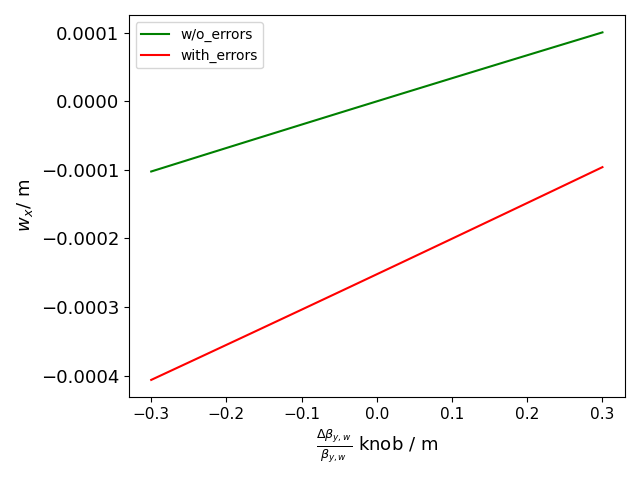

<IPython.core.display.Javascript object>


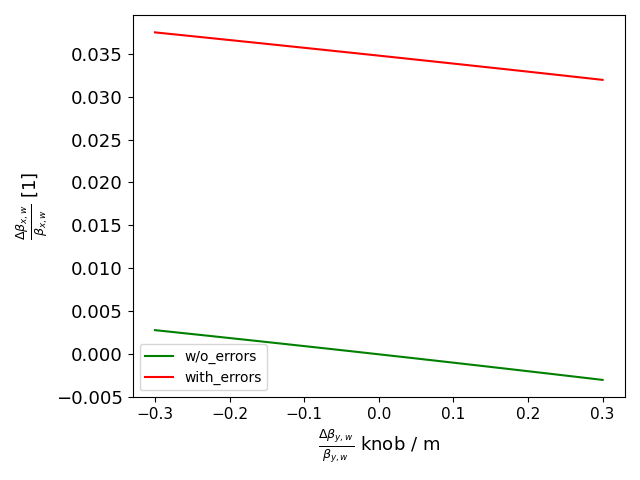

<IPython.core.display.Javascript object>


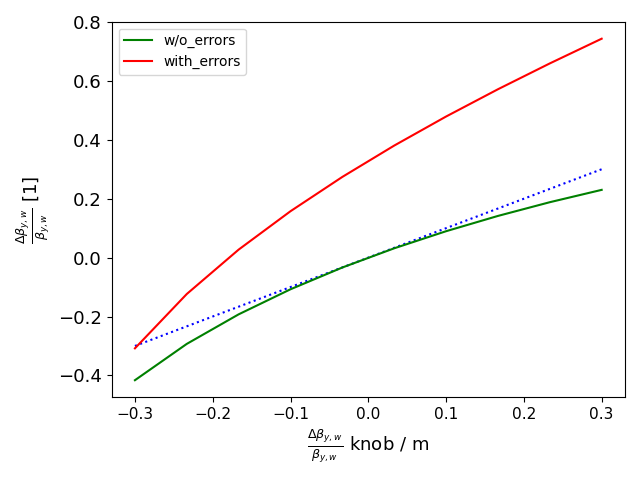

<IPython.core.display.Javascript object>


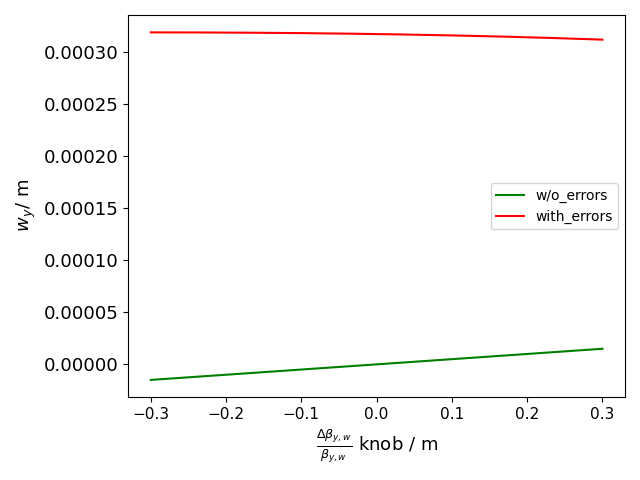

In [10]:
# plot the figures for ideal case and error case

plt.figure()
plt.plot(By_knob,dwx_real,color='green',label='w/o_errors')
plt.plot(By_knob,dwx_error,'r',label='with_errors')

# plt.xlim(-1e-3,1e-3)
# plt.ylim(-1e-3,1e-3)
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\/w_{x}$/ m',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.figure()
plt.plot(By_knob,dbetxw_real,color='green',label='w/o_errors')
plt.plot(By_knob,dbetxw_error,'r',label='with_errors')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\frac{\Delta \beta_{x,w}}{\beta_{x,w}}$ [1]',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.figure()
plt.plot(By_knob,By_knob,'b:')
plt.plot(By_knob,dbetyw_real,color='green',label='w/o_errors')
plt.plot(By_knob,dbetyw_error,'r',label='with_errors')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ [1]',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.figure()
plt.plot(By_knob,dwy_real,color='green',label='w/o_errors')
plt.plot(By_knob,dwy_error,'r',label='with_errors')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\/w_{y}$/ m',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


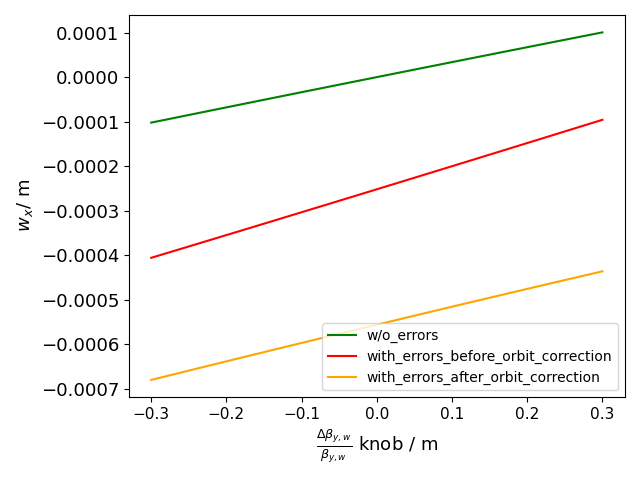

<IPython.core.display.Javascript object>


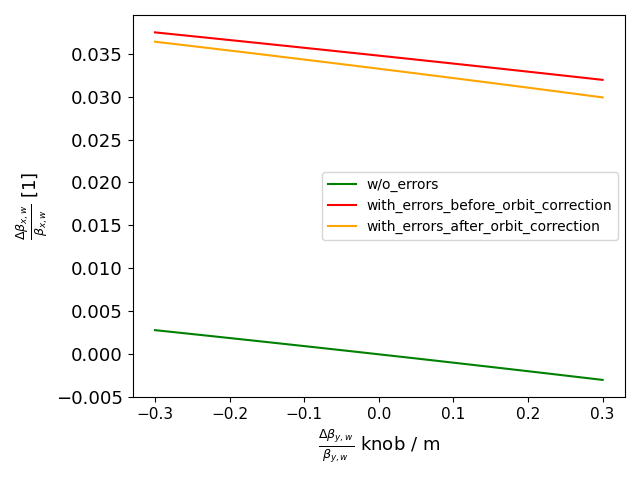

<IPython.core.display.Javascript object>


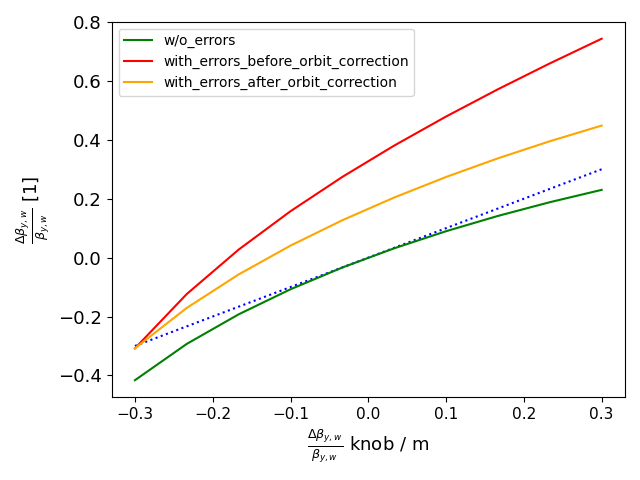

<IPython.core.display.Javascript object>


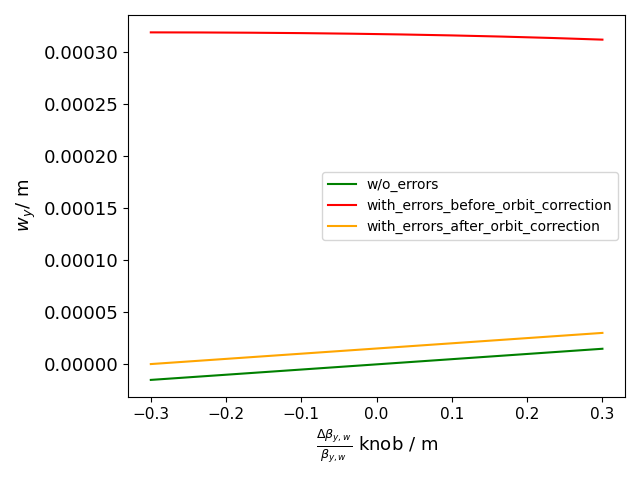

In [11]:
# plot the figures for ideal case,error case and error case after orbit correction

plt.figure()
plt.plot(By_knob,dwx_real,color='green',label='w/o_errors')
plt.plot(By_knob,dwx_error,'r',label='with_errors_before_orbit_correction')
plt.plot(By_knob,dwx_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
# plt.xlim(-1e-3,1e-3)
# plt.ylim(-1e-3,1e-3)
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\/w_{x}$/ m',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.figure()
plt.plot(By_knob,dbetxw_real,color='green',label='w/o_errors')
plt.plot(By_knob,dbetxw_error,'r',label='with_errors_before_orbit_correction')
plt.plot(By_knob,dbetxw_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\frac{\Delta \beta_{x,w}}{\beta_{x,w}}$ [1]',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()

plt.figure()
plt.plot(By_knob,By_knob,'b:')
plt.plot(By_knob,dbetyw_real,color='green',label='w/o_errors')
plt.plot(By_knob,dbetyw_error,'r',label='with_errors_before_orbit_correction')
plt.plot(By_knob,dbetyw_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ [1]',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()


plt.figure()
plt.plot(By_knob,dwy_real,color='green',label='w/o_errors')
plt.plot(By_knob,dwy_error,'r',label='with_errors_before_orbit_correction')
plt.plot(By_knob,dwy_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
plt.legend()
plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
plt.ylabel(r'$\/w_{y}$/ m',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()


# plt.figure()
# plt.plot(By_knob,dQx_real,color='green',label='w/o_errors')
# plt.plot(By_knob,dQx_error,'r',label='with_errors_before_orbit_correction')
# plt.plot(By_knob,dQx_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
# plt.legend()
# plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
# plt.ylabel(r'$\Delta\/Q_{x}$',fontsize=13)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.tight_layout()


# plt.figure()
# plt.plot(By_knob,dQy_real,color='green',label='w/o_errors')
# plt.plot(By_knob,dQy_error,'r',label='with_errors_before_orbit_correction')
# plt.plot(By_knob,dQy_error_orbit_corr,color='orange',label='with_errors_after_orbit_correction')
# plt.legend()
# plt.xlabel(r'$\frac{\Delta \beta_{y,w}}{\beta_{y,w}}$ knob / m',fontsize=13)
# plt.ylabel(r'$\Delta\/Q_{y}$',fontsize=13)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.tight_layout()
plt.show()